# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "quantum"

nb_devices_for_the_run = 20

# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

## Handling IID data

In [8]:
def quantum_step_size(it, L, omega, N): return 1 / (8 * L)

In [9]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

In [10]:
#Transforming into torch.FloatTensor
X_merged = torch.tensor(X_scaled, dtype=torch.float64)
Y_merged = torch.tensor(Y_scaled.values, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")

# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
dim_notebook = X[0].shape[1]
for x in X:
    print("Number of points on this device:", len(x))

Number of points by devices:  2500
There is 20 devices.
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500
Number of points on this device: 2500


In [11]:
# Checking that data is balanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.4808
ratio of state 1 on this device:  0.5092
ratio of state 1 on this device:  0.5064
ratio of state 1 on this device:  0.4744
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5192
ratio of state 1 on this device:  0.4844
ratio of state 1 on this device:  0.494
ratio of state 1 on this device:  0.5236
ratio of state 1 on this device:  0.498
ratio of state 1 on this device:  0.4912
ratio of state 1 on this device:  0.4856
ratio of state 1 on this device:  0.4964
ratio of state 1 on this device:  0.5068
ratio of state 1 on this device:  0.5
ratio of state 1 on this device:  0.4924
ratio of state 1 on this device:  0.4936
ratio of state 1 on this device:  0.4928
ratio of state 1 on this device:  0.4916
ratio of state 1 on this device:  0.51


In [12]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [13]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                               ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-iid-obj_min")

   it    |   obj   
   10000 | 5.4297e-01
   20000 | 5.4297e-01
   30000 | 5.4297e-01
   40000 | 5.4297e-01
Gradient Descent: execution time=4687.020 seconds
Final loss : 0.54297

CPU times: user 3h 33min 6s, sys: 35min 52s, total: 4h 8min 59s
Wall time: 1h 18min 7s


In [14]:
def ratio_failure(index: int, guess: int = 1):
    x = X[index]
    y = Y[index]
    w = obj_min_by_N_descent.model_params[-1]
    mul =  x.mv(w)
    inf_middle = 0
    failure = 0
    for i in range(len(mul)):
        if guess == 1:
            if torch.sigmoid(mul[i]) >= 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
        else:
            if torch.sigmoid(mul[i]) < 0.5:
                if y[i] != guess:
                    failure +=1
                inf_middle +=1
    print("Number of labels equal to " + str(guess) + ": ", inf_middle)
    print("Failures:", failure)
    print("Percent of labels wrongly predicted to be state " + str(guess) +" for worker 0: " + 
          str(failure/inf_middle * 100) + "%")
    
ratio_failure(1, 1)
ratio_failure(0, 1)

Number of labels equal to 1:  1246
Failures: 356
Percent of labels wrongly predicted to be state 1 for worker 0: 28.57142857142857%
Number of labels equal to 1:  1238
Failures: 387
Percent of labels wrongly predicted to be state 1 for worker 0: 31.260096930533116%


In [15]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               step_formula=quantum_step_size,
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-iid-descent")

100%|██████████| 5/5 [26:20:10<00:00, 18962.01s/it]

CPU times: user 20h 2min 50s, sys: 7min 39s, total: 20h 10min 29s
Wall time: 1d 2h 20min 10s


In [16]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-1.3494e-02, -6.8809e-03,  4.1352e-02, -4.2375e-02,  7.3730e-01,
         3.5704e-03, -1.0915e-02,  1.5517e-02,  2.5387e-01,  1.0405e-02,
         2.7300e-02,  1.9985e-03, -2.6709e-02,  1.0214e+00,  4.2038e-01,
         1.1981e-01, -2.1260e-02, -4.0603e-02,  1.5264e-03,  1.3468e-02,
        -1.7042e-02, -3.0125e-02,  2.1454e-02,  5.0315e-02, -2.1344e-02,
         6.7662e-02, -3.8299e-02, -1.1311e-01,  4.7663e-02, -4.9348e-02,
        -3.8202e-02,  3.2482e-02,  2.0050e-02,  3.7529e-02,  7.1673e-03,
        -5.1172e-03, -5.3779e-02,  2.0519e-02,  3.8129e-02,  1.0974e-02,
         1.3238e-02, -7.2326e-03, -4.7154e-02, -9.0619e-02, -7.0764e-02,
         7.1029e-02,  6.8190e-02, -2.0629e-02,  6.7808e-04, -5.4890e-03,
         1.4786e-01,  8.6216e-03, -7.4912e-03,  1.4010e-01, -7.5630e-03,
        -5.2972e-02, -1.0900e-01, -2.7347e-03,  3.1280e-01, -5.1700e-02,
         1.3226e-02,  1.4861e-02, -6.0715e-

### With averaging

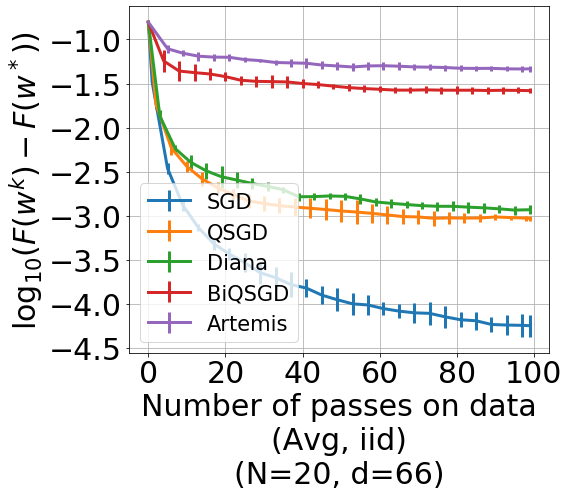

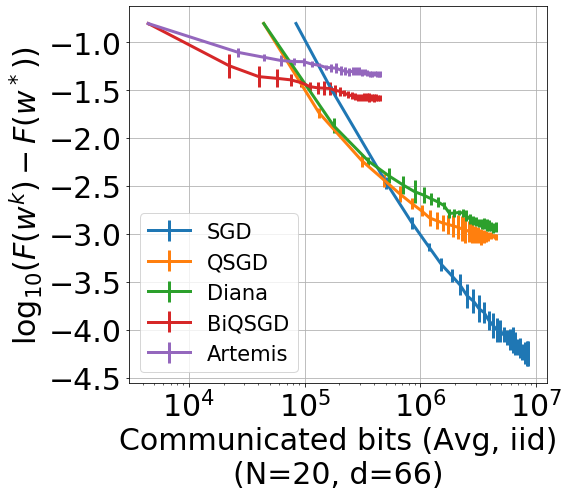

In [17]:
obj = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), x_legend="Number of passes on data\n(Avg, iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, iid)") 


### Without averaging

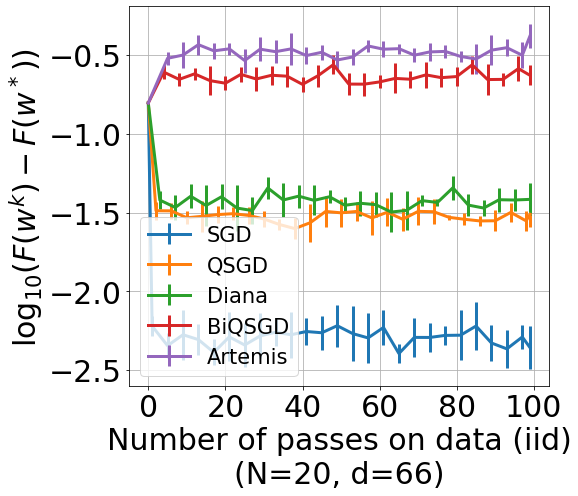

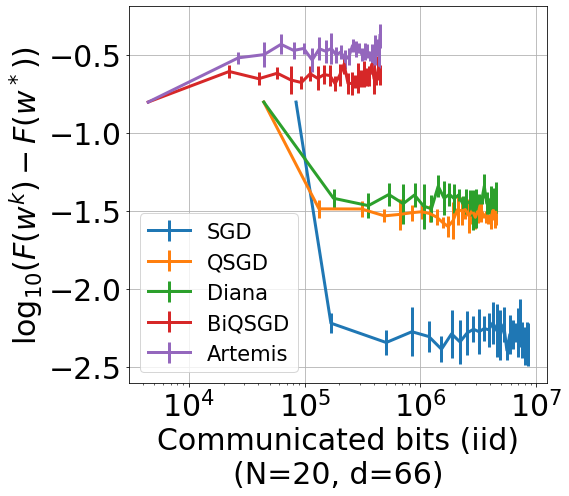

In [18]:
obj_min_by_N = pickle_loader(filename + "-iid-obj_min")
res = pickle_loader(filename + "-iid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_legend="Number of passes on data (iid)", all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (iid)", all_error=res.get_std(obj)) 

# Handling non-iid data

CPU times: user 1h 1min 58s, sys: 2min 32s, total: 1h 4min 30s
Wall time: 11min 56s


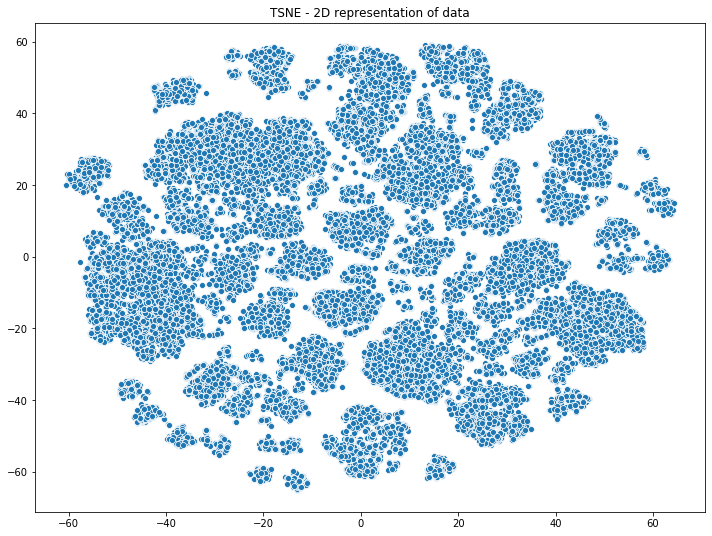

In [19]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tsne(data)
pickle_saver(embedded_data, filename + "-tsne")

There is 20 devices.
Number of points on device 0 : 2384
Number of points on device 1 : 2674
Number of points on device 2 : 2505
Number of points on device 3 : 1121
Number of points on device 4 : 2235
Number of points on device 5 : 1823
Number of points on device 6 : 4358
Number of points on device 7 : 1858
Number of points on device 8 : 2479
Number of points on device 9 : 1790
Number of points on device 10 : 1389
Number of points on device 11 : 2004
Number of points on device 12 : 1735
Number of points on device 13 : 2215
Number of points on device 14 : 1095
Number of points on device 15 : 10572
Number of points on device 16 : 2486
Number of points on device 17 : 898
Number of points on device 18 : 1382
Number of points on device 19 : 2997
CPU times: user 9min 16s, sys: 5.48 s, total: 9min 21s
Wall time: 2min 21s


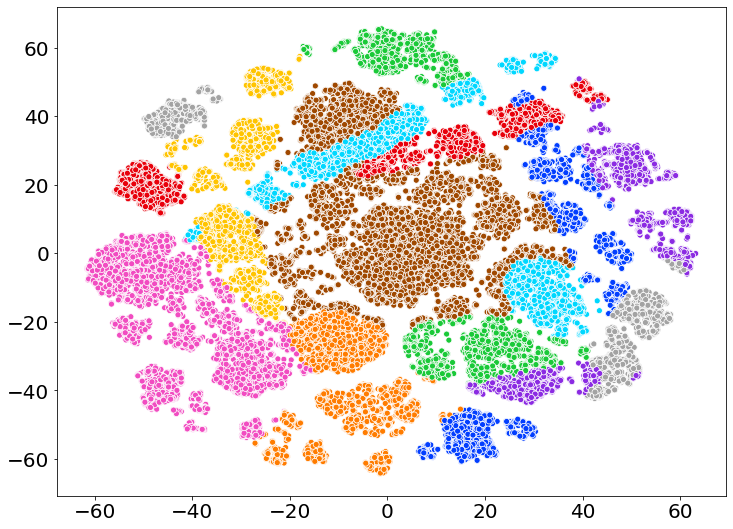

In [8]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader(filename + "-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1]

CPU times: user 59min 47s, sys: 2min 38s, total: 1h 2min 25s
Wall time: 10min 4s


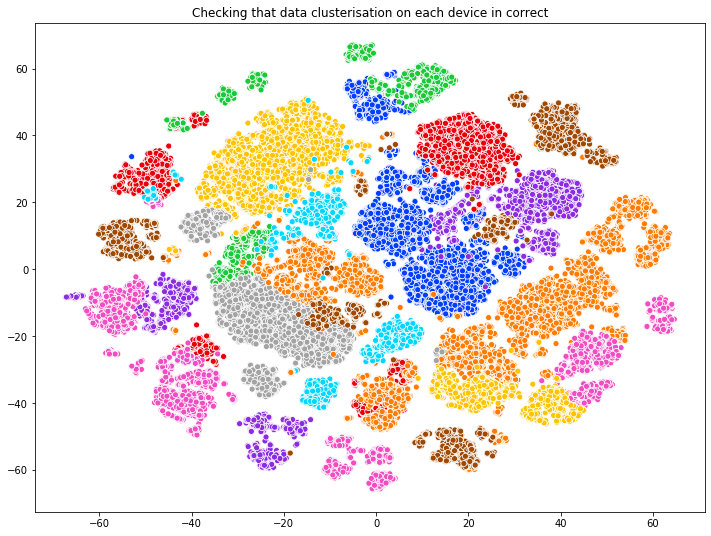

In [21]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [9]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.438758389261745
ratio of state 1 on this device:  0.5254300673148841
ratio of state 1 on this device:  0.5141716566866268
ratio of state 1 on this device:  0.7528991971454059
ratio of state 1 on this device:  0.44474272930648767
ratio of state 1 on this device:  0.8332419089413056
ratio of state 1 on this device:  0.31551170261587885
ratio of state 1 on this device:  0.4580193756727664
ratio of state 1 on this device:  0.918918918918919
ratio of state 1 on this device:  0.5636871508379888
ratio of state 1 on this device:  0.23542116630669546
ratio of state 1 on this device:  0.9995009980039921
ratio of state 1 on this device:  0.5919308357348703
ratio of state 1 on this device:  0.4853273137697517
ratio of state 1 on this device:  0.245662100456621
ratio of state 1 on this device:  0.4337873628452516
ratio of state 1 on this device:  0.01488334674175382

In [23]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X, Y, nb_devices_for_the_run)

In [24]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 5.1194e-01
   20000 | 5.1194e-01
   30000 | 5.1194e-01
   40000 | 5.1194e-01
Gradient Descent: execution time=586.973 seconds
Final loss : 0.51194

CPU times: user 2h 19min 29s, sys: 7min 52s, total: 2h 27min 22s
Wall time: 9min 47s


## Batch size $= 1$ (stochastic)

In [25]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, 
                                               step_formula=quantum_step_size,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
pickle_saver(res, filename + "-noniid-descent")

100%|██████████| 5/5 [3:35:44<00:00, 2588.93s/it]

CPU times: user 5h 22min 49s, sys: 7min 37s, total: 5h 30min 27s
Wall time: 3h 35min 44s


### With averaging

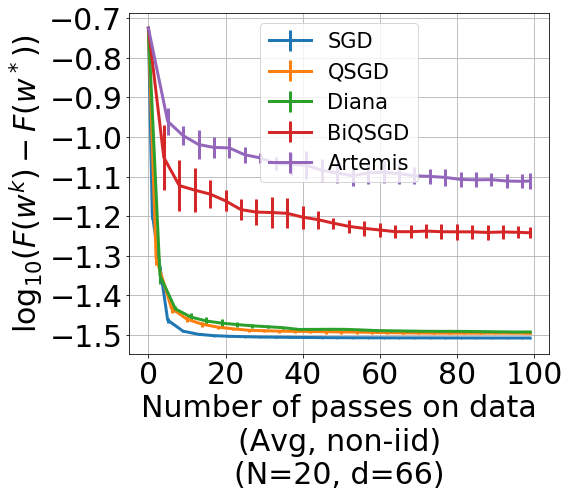

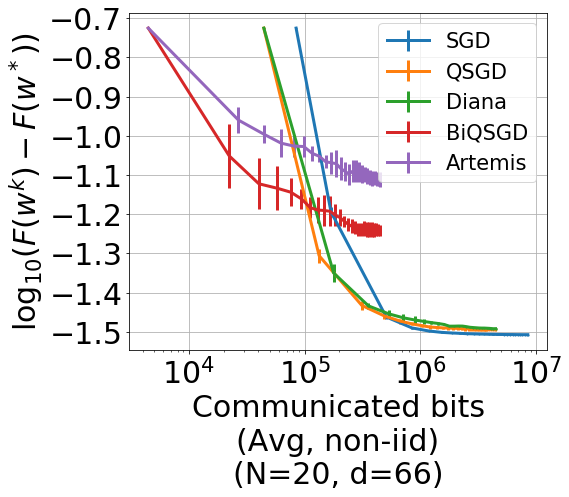

In [26]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

### Without averaging

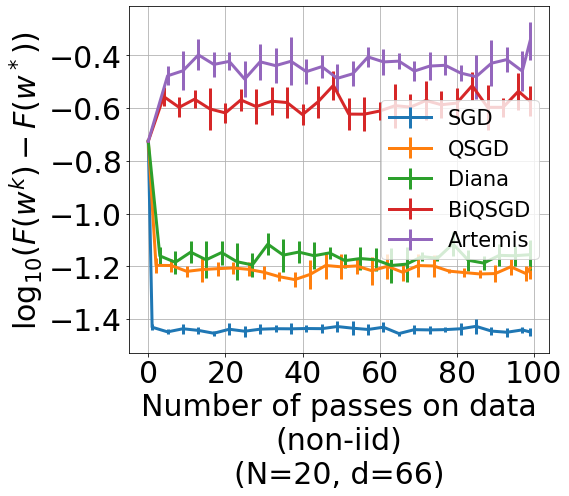

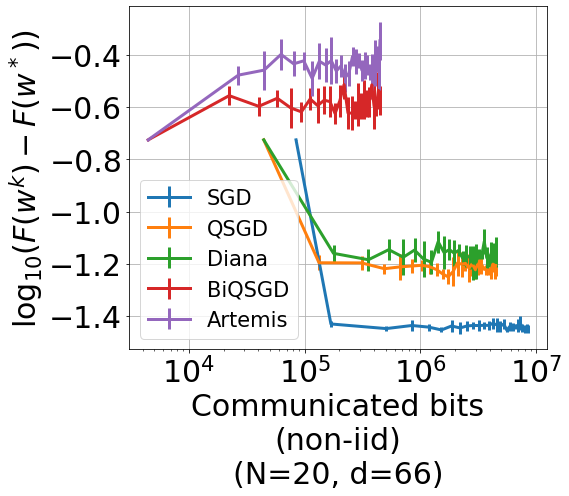

In [27]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

## Batch size $= 400$

In [28]:
%%time
batch_size = 400
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=True, batch_size=batch_size, 
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-{1}".format(filename, batch_size))

100%|██████████| 5/5 [1:03:55<00:00, 767.19s/it]

CPU times: user 15h 2min 48s, sys: 56min 31s, total: 15h 59min 20s
Wall time: 1h 3min 56s


### Without averaging

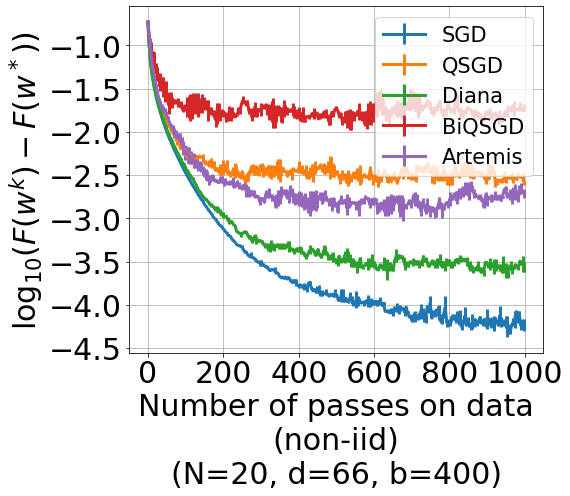

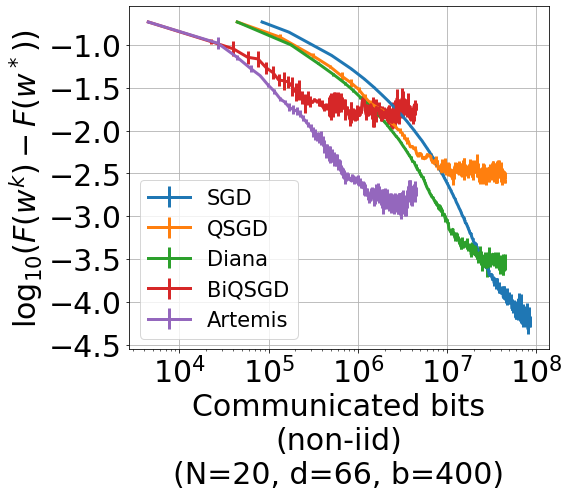

In [12]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

In [14]:
batch_size = 400
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(Avg, non-iid)", all_error=res.get_std(obj, averaged=True)) 

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 576x504 with 0 Axes>